Load in the MNIST dataset and establish our feature vector (x) and our label vector (y).

In [1]:
#Nneed these depending on user 
%pip install pot
%pip install numpy
%pip install matplotlib
%pip install pandas
import ot
from sklearn.datasets import fetch_openml
import numpy as np


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


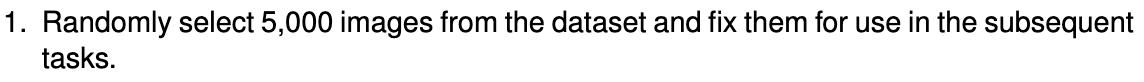

In [2]:
#Load data in
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=int)

#Pick only 5000
np.random.seed(0)
indices = np.random.choice(len(X), 5000, replace=False) 
X_subset = X[indices]        #Features
y_subset = y[indices]        #Labels

#See what arrays look like
print("X_subset shape:", X_subset.shape)
print("y_subset shape:", y_subset.shape)
print(X_subset[0])
print(y_subset[0])



X_subset shape: (5000, 784)
y_subset shape: (5000,)
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  89.
 147. 147. 249. 230.  59.   2.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  15. 160. 249.
 254. 254. 254. 254. 254. 122.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   8. 188. 254. 254.
 254. 250. 147. 166. 253.

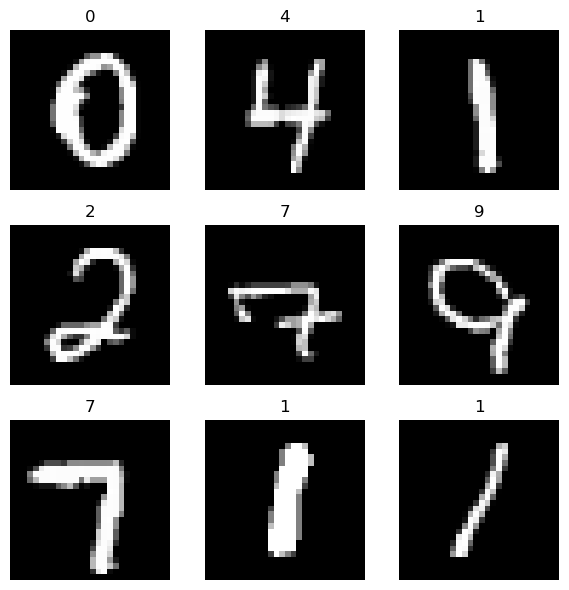

In [3]:
#More visualization - Not important to project, just helps to see data
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_subset[i].reshape(28, 28), cmap='gray')
    plt.title(int(y_subset[i]))
    plt.axis('off')
plt.tight_layout()
plt.show()


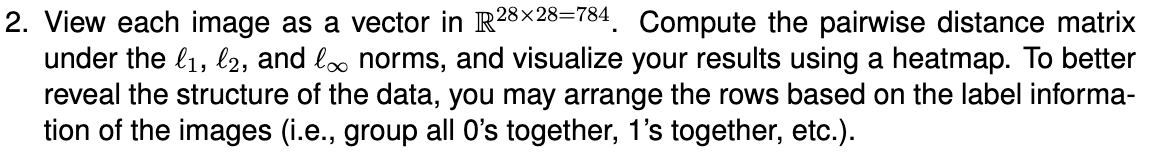

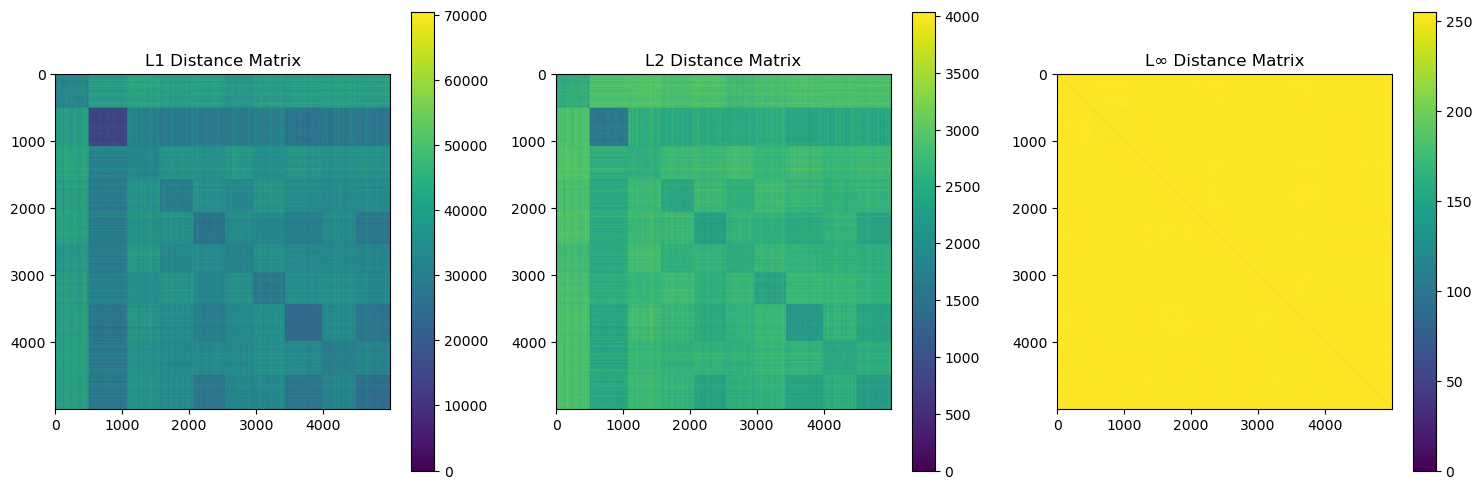

In [4]:
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# Sort indices based on labels
sorted_indices = np.argsort(y_subset)
X_sorted = X_subset[sorted_indices]

# Calculate pairwise distances using different norms
l1_distances = cdist(X_sorted[:5000], X_sorted[:5000], metric='cityblock')  # L1 norm
l2_distances = cdist(X_sorted[:5000], X_sorted[:5000], metric='euclidean')  # L2 norm
linf_distances = cdist(X_sorted[:5000], X_sorted[:5000], metric='chebyshev')  # L infinity norm

# Create figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot heatmaps
im1 = ax1.imshow(l1_distances, cmap='viridis')
im2 = ax2.imshow(l2_distances, cmap='viridis')
im3 = ax3.imshow(linf_distances, cmap='viridis')

# Add titles and colorbars
ax1.set_title('L1 Distance Matrix')
ax2.set_title('L2 Distance Matrix')
ax3.set_title('L∞ Distance Matrix')

plt.colorbar(im1, ax=ax1)
plt.colorbar(im2, ax=ax2)
plt.colorbar(im3, ax=ax3)

plt.tight_layout()
plt.show()


In the images for the L1, L2, and L∞ distance matrices we are looking for a darker shaded diagonal line across each matrix. This shows that for each number, the distance from one image to another image of the same number, should be very small. In comparison we see much lighter colors, (symbolizing more distance) when comparing two numbers that are not the same.  

Briefly constrasting the L1 and L2 heatmaps, we see that the L1 heatmap tends to calculate a distance around 4000 where the L2 heatmap tends to calculate a distance around 3000. This makes sense considering the formula for L1 distance calculates a larger distance than L2 on many data points. Lastly, in the L∞ distance matrix we see an almost entirely yellow graph with a faint diagonal. This makes sense given that the maximum distance for two dimensions on two images is 255 and that there will almost always be a maximum of 255 from one image to another.

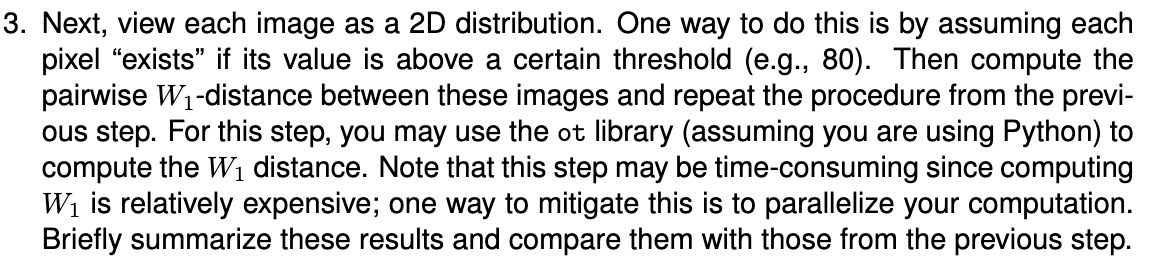

|  
|  
|  
|  
Here N is = 200 for the submision, but to run truly correct N should = 5000.  
We had a run where we could store all the data with N = 5000 but lost it and ran out of time  
to re-run (very computationally expensive), so change N = 5000 for full results  
|  
|  
|  
|  

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

# Binarize and normalize each image to a probability distribution
N = 200                                       # Used subset for testing and full for final run
imgs = X_sorted[:N].reshape(N, 28, 28).astype(np.float32)   
threshold = 80.0                       # Binarization threshold
binary = (imgs > threshold).astype(np.float32)
a = binary.reshape(N, -1)                        
a_sum = a.sum(axis=1, keepdims=True)
a = a / (a_sum + 1e-8)                           

# Build the ground-cost matrix 
h, w = 28, 28
yy, xx = np.meshgrid(np.arange(h, dtype=np.float32), np.arange(w, dtype=np.float32), indexing='ij')
coords = np.stack([yy.ravel(), xx.ravel()], axis=1)   # shape: (784, 2)
M = ot.dist(coords, coords, metric='euclidean').astype(np.float32)  # shape: (784, 784)
M /= M.max() + 1e-8  # Normalization for numeric stability

# Pairwise W1 computations (parallelized over the upper triangle)
def w1_pair(i, j):
    return float(ot.emd2(a[i], a[j], M))

# Compute W1 distance matrix usign parallelization
pairs = [(i, j) for i in range(N) for j in range(i, N)]
vals = Parallel(n_jobs=-1, prefer="threads")(delayed(w1_pair)(i, j) for (i, j) in pairs)
W1 = np.zeros((N, N), dtype=np.float32)
for v, (i, j) in zip(vals, pairs):
    W1[i, j] = v
    W1[j, i] = v

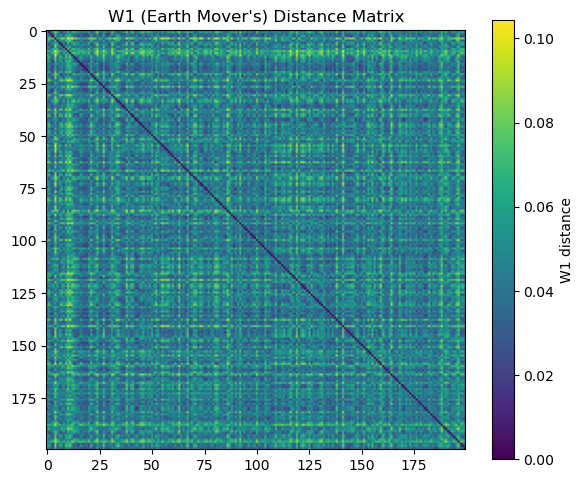

In [6]:
# Visualize - Separated out becuase calculating W1 is computationally expensive
plt.figure(figsize=(6, 5))
plt.imshow(W1, cmap='viridis')
plt.title('W1 (Earth Mover\'s) Distance Matrix')
plt.colorbar(label='W1 distance')
plt.tight_layout()
plt.show()

To briefly summarize the Wasserstein distance (W1-distance), this distance has every image as a probability distribution and measures the minimum distance from transporting one distribution to another. The distance under the W1-distance is smaller relative to the distances calculated in the prior step. This is because the distances calcuated in step two will over amplify small shifts in handwriting, whereas the Wasserstein distance handles these small shifts much better.  

Overall the heatmap looks very similar to the heatmaps from step 2, containing a dark diagonal surrounded by lighter blocks. Some more similarities are that the ℓ1, ℓ2, and W1 heatmaps contain what looks like a 10x10 matrix inside, this is representitave of the 0-9 digits. The difference in the two is reflected in the overall distance. The ℓ1 and ℓ2 heatmaps are primarily made up of distances ranging from 3000-4000 whereas the W1 heatmap consolidates with distances less than the ℓ1 and ℓ2 heatmaps becuase it is not thrown off as much by the small shifts in handwriting.


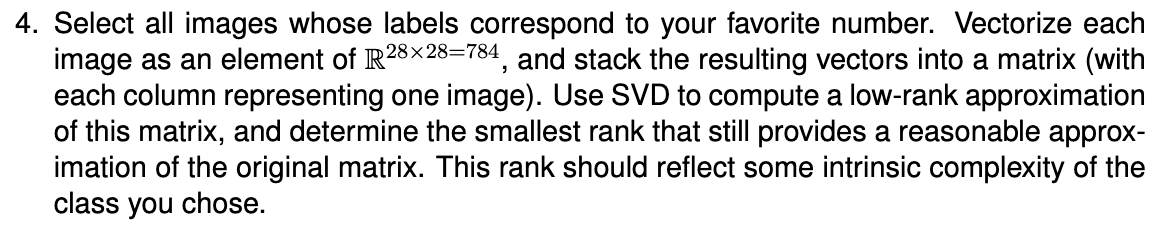

Digit 1: found 573 images in the 5000-sample subset.


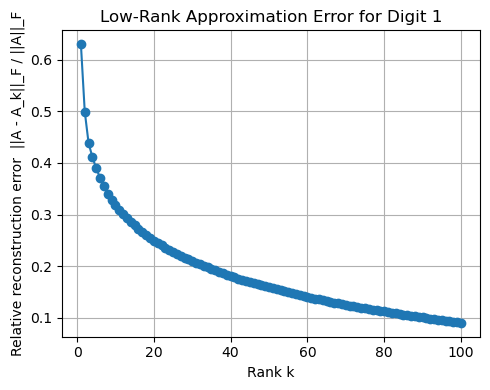

Smallest rank k with <10% error: k = 91


In [7]:
import numpy as np
import matplotlib.pyplot as plt

#choose favorite digit
fav_digit = 1 

# Grab all images of that digit from the 5000 subset
mask_fav = (y_subset == fav_digit)
X_fav = X_subset[mask_fav]        # shape: (m, 784)
m = X_fav.shape[0]
print(f"Digit {fav_digit}: found {m} images in the 5000-sample subset.")


# Build data matrix A where each column is one flattened image
# A will be 784 x m
A = X_fav.T

# Compute economical SVD
U, S, Vt = np.linalg.svd(A, full_matrices=False)
# S contains singular values; S^2 is the "energy" captured by each mode.

total_energy = np.sum(S**2)

# Track relative reconstruction error vs rank k
Rmax = min(100, len(S))   # we don't need to go past 50 for the plot
rel_errors = []
for k in range(1, Rmax+1):
    energy_k = np.sum(S[:k]**2)
    rel_err = np.sqrt(1 - energy_k / total_energy)
    rel_errors.append(rel_err)

# Plot error curve
plt.figure(figsize=(5,4))
plt.plot(range(1, Rmax+1), rel_errors, marker='o')
plt.xlabel("Rank k")
plt.ylabel("Relative reconstruction error  ||A - A_k||_F / ||A||_F")
plt.title(f"Low-Rank Approximation Error for Digit {fav_digit}")
plt.grid(True)
plt.tight_layout()
plt.show()

# Smallest k that gets us under 10% error
best_k = None
for k, err in enumerate(rel_errors, start=1):
    if err < 0.10 and best_k is None:
        best_k = k

if best_k is not None:
    print(f"Smallest rank k with <10% error: k = {best_k}")
else:
    print("Did not get below 10% error within first 50 ranks.")



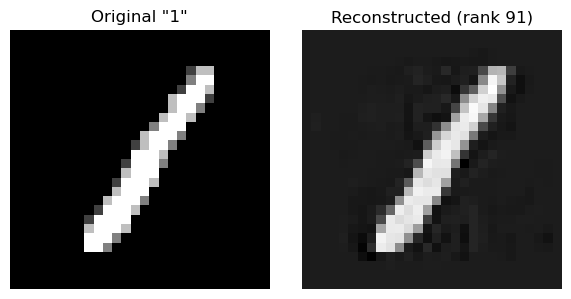

In [8]:
j = np.random.randint(A.shape[1])  # random image of digit "1"
orig = A[:, j].reshape(28, 28)     # original image of random selection

# rank-k reconstruction of column j without forming full A_k
U_k, S_k, Vt_k = U[:, :best_k], S[:best_k], Vt[:best_k, :]
recon = (U_k @ (S_k[:, None] * Vt_k[:, j:j+1])).reshape(28, 28)

# Show original and reconstructed images side by side
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(orig, cmap='gray')
plt.title('Original "1"'); plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(recon, cmap='gray')
plt.title(f'Reconstructed (rank {best_k})')
plt.axis('off')
plt.tight_layout(); plt.show()


From step 4, we can see that the number 1 will converge to an absolute error below 10% at rank 91. To vsiualize the smallest rank that still provides a reasonable approximation of the original matrix, we show the above visual. Which shows how close our rank one approximation is to the original of that image.

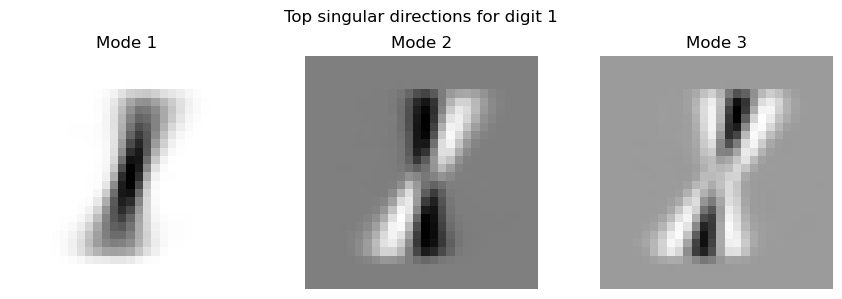

In [9]:
# Visualize first few singular vectors ("eigendigits")
modes_to_show = 3
plt.figure(figsize=(3*modes_to_show, 3))
for i in range(modes_to_show):
    mode_img = U[:, i].reshape(28, 28)
    plt.subplot(1, modes_to_show, i+1)
    plt.imshow(mode_img, cmap='gray')
    plt.title(f"Mode {i+1}")
    plt.axis('off')
plt.suptitle(f"Top singular directions for digit {fav_digit}")
plt.tight_layout()
plt.show()